In [1]:
# Set Jupyter to render directly to the screen
%matplotlib inline
import matplotlib as plt
# Import pandas and numpy for analysis, as well as package math
import pandas as pd
import numpy as np
import math as math

# Importing the Analysis Functions from the external Python Module

In [2]:
# Import the functions to do the cointegration analysis. This requires that 'cointegration_analysis.py' is in the same 
# directory as this notebook.

from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test

In [3]:
# We can use the help() function in Python to bring up the docstrings. Alternatively, we could have used shift-tab while 
# highlighint the function name or looked in the cointegration_analysis.py file itself.

help(estimate_long_run_short_run_relationships)

Help on function estimate_long_run_short_run_relationships in module cointegration_analysis:

estimate_long_run_short_run_relationships(y, x)
    Estimates long-run and short-run cointegration relationship for series y and x. 
    
    Uses a 2-step process to first estimate coefficients for the long-run relationship
        y_t = c + gamma * x_t + z_t
        
    and then the short-term relationship,
        y_t - y_(t-1) = alpha * z_(t-1) + epsilon_t,
        
    with z the found residuals of the first equation.
    
    Parameters
    ----------
    y : pd.Series
        The first time series of the pair to analyse.
    
    x : pd.Series
        The second time series of the pair to analyse.
    
    Returns
    -------
    c : float
        The constant term in the long-run relationship y_t = c + gamma * x_t + z_t. This 
        describes the static shift of y with respect to gamma * x.
        
    gamma : float
        The gamma term in the long-run relationship y_t = c + gamm

In [4]:
help(engle_granger_two_step_cointegration_test)

Help on function engle_granger_two_step_cointegration_test in module cointegration_analysis:

engle_granger_two_step_cointegration_test(y, x)
    Applies the two-step Engle & Granger test for cointegration. 
    
    First fits the long-run relationship
        y_t = c + gamma * x_t + z_t
    
    and then tests, by Dickey-Fuller phi=1 vs phi < 1 in
        z_t = phi * z_(t-1) + eta_t
        
    If this implies phi < 1, the z series is stationary is concluded to be
    stationary, and thus the series y and x are concluded to be cointegrated.
    
    Parameters
    ----------
    y : pd.Series
        the first time series of the pair to analyse
    
    x : pd.Series
        the second time series of the pair to analyse
        
    Returns
    -------
    dfstat : float
        The Dickey Fuller test-statistic for phi = 1 vs phi < 1 in the second equation. A more 
        negative value implies the existence of stronger cointegration.
    
    pvalue : float
        The p-value cor

# Reading in the CSV file

In [5]:
def read_data(filename):
    '''
    This function reads the .csv stored at the 'filename' location and returns a DataFrame
    with two levels of column names. The first level column contains the Stock Name and the 
    second contains the type of market data, e.g. bid/ask, price/volume.
    '''
    df = pd.read_csv(filename, index_col=0)
    df.columns = [df.columns.str[-2:], df.columns.str[:-3]]

    return df

In [6]:
# Read the market data

filename = 'Pairs Trading.csv'
market_data = read_data(filename)

In [7]:
# Get all the stock names into a list

stock_names = list(market_data.columns.get_level_values(0).unique())

print(stock_names)

['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'II', 'JJ', 'KK', 'LL', 'MM', 'NN', 'OO']


# Some Examples

In [8]:
# What is in the dataframe? (Display top 5 rows with the .head() DataFrame method.)

market_data.head()

AA                                    BB            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00    80.00     135.0    80.25     135.0   100.55     105.0   
2018-01-01 00:10:00    79.95     124.0    80.20     145.0   100.50     104.0   
2018-01-01 00:15:00    79.95     124.0    80.15     155.0   100.65     100.0   
2018-01-01 00:20:00    79.95     130.0    80.10     154.0   100.75     112.0   
2018-01-01 00:25:00    79.90     121.0    80.10     138.0   100.60     126.0   

                                             CC              ...          MM  \
                    AskPrice AskVolume BidPrice BidVolume    ...    AskPrice   
2018-01-01 00:05:00   100.85     105.0    97.85     112.0    ...       95.20   
2018-01-01 00:10:00   100.80     113.0    97.80     109.0    ...       95.20   
2018-01-01 00:15:00   100.95     107.0    97.85     110.0    ...       95.25   
2018-01-01 00:20:00   101.05     109.0    97.95     100.0    ...       95.25   
2018-01-01 00:25:00   100.85     124.0    97.95      98.0    ...       95.20   

                                    NN                                    OO  \
                    AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice   
2018-01-01 00:05:00     140.0   137.20     122.0   137.60     122.0    88.80   
2018-01-01 00:10:00     144.0   137.20     111.0   137.55     110.0    88.75   
2018-01-01 00:15:00     156.0   137.25     117.0   137.65     106.0    88.70   
2018-01-01 00:20:00     153.0   137.25     107.0   137.65      97.0    88.75   
2018-01-01 00:25:00     153.0   137.15     111.0   137.60     109.0    88.75   

                                                  
                    BidVolume AskPrice AskVolume  
2018-01-01 00:05:00     109.0    89.05     109.0  
2018-01-01 00:10:00     115.0    89.00     100.0  
2018-01-01 00:15:00      92.0    89.00     100.0  
2018-01-01 00:20:00     100.0    89.00     113.0  
2018-01-01 00:25:00      98.0    89.00     112.0  

[5 rows x 60 columns]

In [9]:
# Extracting the BidVolumes of AA. Note how the printed output is formatted differently 
# from the output printed for the whole DataFrame, to indicate that the single column 
# we extracted is a Series.

bid_volumes_AA = market_data['AA', 'BidVolume']
bid_volumes_AA.head()

2018-01-01 00:05:00    135.0
2018-01-01 00:10:00    124.0
2018-01-01 00:15:00    124.0
2018-01-01 00:20:00    130.0
2018-01-01 00:25:00    121.0
Name: (AA, BidVolume), dtype: float64

In [10]:
# Extracting the BidVolume at a specific time. This is just a number (float).

time = '2018-01-05 10:20:00'

bid_volume_AA_at_time = market_data.loc[time, ('AA', 'BidVolume')]
bid_volume_AA_at_time

143.0

In [11]:
# Extracting a subset of observations, here the 1220th to the 1225th.

market_data.iloc[1220:1225]

AA                                    BB            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-05 05:45:00    81.80     120.0    82.05     109.0    93.75      87.0   
2018-01-05 05:50:00    81.85     123.0    82.10     109.0    93.70      91.0   
2018-01-05 05:55:00    81.85     118.0    82.10     128.0    93.85      98.0   
2018-01-05 06:00:00    81.85     121.0    82.10     124.0    93.90      90.0   
2018-01-05 06:05:00    81.85     116.0    82.05     124.0    93.95      90.0   

                                             CC              ...          MM  \
                    AskPrice AskVolume BidPrice BidVolume    ...    AskPrice   
2018-01-05 05:45:00    94.00     115.0    97.70     114.0    ...       94.65   
2018-01-05 05:50:00    93.95     100.0    97.75     107.0    ...       94.65   
2018-01-05 05:55:00    94.05      93.0    97.75     101.0    ...       94.65   
2018-01-05 06:00:00    94.15      74.0    97.80      84.0    ...       94.70   
2018-01-05 06:05:00    94.20      76.0    97.70      87.0    ...       94.80   

                                    NN                                    OO  \
                    AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice   
2018-01-05 05:45:00     135.0   137.00     130.0   137.35     110.0    89.85   
2018-01-05 05:50:00     136.0   136.90     133.0   137.25     108.0    89.85   
2018-01-05 05:55:00     136.0   136.95     113.0   137.30     124.0    89.85   
2018-01-05 06:00:00     144.0   136.95     112.0   137.30     116.0    89.85   
2018-01-05 06:05:00     130.0   137.00     114.0   137.35     127.0    89.90   

                                                  
                    BidVolume AskPrice AskVolume  
2018-01-05 05:45:00     131.0    90.15     112.0  
2018-01-05 05:50:00     132.0    90.10     109.0  
2018-01-05 05:55:00     136.0    90.15     107.0  
2018-01-05 06:00:00     149.0    90.15     126.0  
2018-01-05 06:05:00     152.0    90.20     122.0  

[5 rows x 60 columns]

In [12]:
# Adding a new column based on a calculation of old columns
# NOTE: The new column gets added to the far right of the DataFrame

bid_ask_spread_AA = market_data['AA', 'AskPrice'] - market_data['AA', 'BidPrice']

market_data['AA', 'BidAskSpread'] = bid_ask_spread_AA

market_data.head()

AA                                    BB            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00    80.00     135.0    80.25     135.0   100.55     105.0   
2018-01-01 00:10:00    79.95     124.0    80.20     145.0   100.50     104.0   
2018-01-01 00:15:00    79.95     124.0    80.15     155.0   100.65     100.0   
2018-01-01 00:20:00    79.95     130.0    80.10     154.0   100.75     112.0   
2018-01-01 00:25:00    79.90     121.0    80.10     138.0   100.60     126.0   

                                             CC               ...       \
                    AskPrice AskVolume BidPrice BidVolume     ...        
2018-01-01 00:05:00   100.85     105.0    97.85     112.0     ...        
2018-01-01 00:10:00   100.80     113.0    97.80     109.0     ...        
2018-01-01 00:15:00   100.95     107.0    97.85     110.0     ...        
2018-01-01 00:20:00   101.05     109.0    97.95     100.0     ...        
2018-01-01 00:25:00   100.85     124.0    97.95      98.0     ...        

                           MM       NN                                    OO  \
                    AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice   
2018-01-01 00:05:00     140.0   137.20     122.0   137.60     122.0    88.80   
2018-01-01 00:10:00     144.0   137.20     111.0   137.55     110.0    88.75   
2018-01-01 00:15:00     156.0   137.25     117.0   137.65     106.0    88.70   
2018-01-01 00:20:00     153.0   137.25     107.0   137.65      97.0    88.75   
2018-01-01 00:25:00     153.0   137.15     111.0   137.60     109.0    88.75   

                                                           AA  
                    BidVolume AskPrice AskVolume BidAskSpread  
2018-01-01 00:05:00     109.0    89.05     109.0         0.25  
2018-01-01 00:10:00     115.0    89.00     100.0         0.25  
2018-01-01 00:15:00      92.0    89.00     100.0         0.20  
2018-01-01 00:20:00     100.0    89.00     113.0         0.15  
2018-01-01 00:25:00      98.0    89.00     112.0         0.20  

[5 rows x 61 columns]

In [13]:
# The resulting DataFrame still looks a bit disordered, with the new AA column not alongside
# the other AA columns. We can alphabetically sort the column names to clean things up a bit.

market_data = market_data.sort_index(axis=1)
market_data.head()

AA                                            \
                    AskPrice AskVolume BidAskSpread BidPrice BidVolume   
2018-01-01 00:05:00    80.25     135.0         0.25    80.00     135.0   
2018-01-01 00:10:00    80.20     145.0         0.25    79.95     124.0   
2018-01-01 00:15:00    80.15     155.0         0.20    79.95     124.0   
2018-01-01 00:20:00    80.10     154.0         0.15    79.95     130.0   
2018-01-01 00:25:00    80.10     138.0         0.20    79.90     121.0   

                          BB                                    CC    ...     \
                    AskPrice AskVolume BidPrice BidVolume AskPrice    ...      
2018-01-01 00:05:00   100.85     105.0   100.55     105.0    98.10    ...      
2018-01-01 00:10:00   100.80     113.0   100.50     104.0    98.15    ...      
2018-01-01 00:15:00   100.95     107.0   100.65     100.0    98.15    ...      
2018-01-01 00:20:00   101.05     109.0   100.75     112.0    98.20    ...      
2018-01-01 00:25:00   100.85     124.0   100.60     126.0    98.30    ...      

                          MM                 NN                               \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00    94.90     140.0   137.60     122.0   137.20     122.0   
2018-01-01 00:10:00    94.90     156.0   137.55     110.0   137.20     111.0   
2018-01-01 00:15:00    94.95     140.0   137.65     106.0   137.25     117.0   
2018-01-01 00:20:00    95.00     121.0   137.65      97.0   137.25     107.0   
2018-01-01 00:25:00    94.95     150.0   137.60     109.0   137.15     111.0   

                          OO                               
                    AskPrice AskVolume BidPrice BidVolume  
2018-01-01 00:05:00    89.05     109.0    88.80     109.0  
2018-01-01 00:10:00    89.00     100.0    88.75     115.0  
2018-01-01 00:15:00    89.00     100.0    88.70      92.0  
2018-01-01 00:20:00    89.00     113.0    88.75     100.0  
2018-01-01 00:25:00    89.00     112.0    88.75      98.0  

[5 rows x 61 columns]

In [14]:
# If we want to iterate over each timestamp, we can easily do so. As practice, let's 
# calculate the maximum BidAskSpread of AA seen in the whole dataset.

max_spread_seen = 0
max_spread_seen_time = None

for time, mkt_data_at_time in market_data.iterrows():
    spread = mkt_data_at_time['AA', 'BidAskSpread'] 
    
    if spread > max_spread_seen:
        max_spread_seen = spread
        max_spread_seen_time = time

print(max_spread_seen_time, max_spread_seen)

2018-01-16 18:25:00 0.4499999999999744


In [15]:
# Now let's do a comparison between different timestamps. We will calculate the maximum 
# price-increase of the AA BidPrice for the whole dataset.

max_price_increase = -999999
max_price_increase_seen_time = None

prev_time = None

for time, mkt_data_at_time in market_data.iterrows():
    if prev_time == None:
        # Skip the first observation, there is no previous bid price to compare to yet.
        prev_time = time
        continue
    
    previous_bid_price = market_data.loc[prev_time, ('AA', 'BidPrice')]  
    current_bid_price = mkt_data_at_time['AA', 'BidPrice']
       
    bid_price_increase = current_bid_price - previous_bid_price
    
    if bid_price_increase > max_price_increase:
        max_price_increase = bid_price_increase
        max_price_increase_seen_time = time
        
    # Update the previous time for the next iteration of the loop.
    prev_time = time

print(max_price_increase_seen_time, max_price_increase)

2018-01-24 01:25:00 0.20000000000001705


# Exercise

In [16]:
# Now it's your turn. Start with plotting some of the values in the market_data DataFrame. Next, apply
# the analysis functions imported above. Finally design and backtest a trading algorithm exploiting
# the cointegration relationships found in the data.


# Analysis

In [17]:
# Load and eplore dataset
filename = 'Pairs Trading.csv'
market_data = read_data(filename)

market_data.head()

AA                                    BB            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00    80.00     135.0    80.25     135.0   100.55     105.0   
2018-01-01 00:10:00    79.95     124.0    80.20     145.0   100.50     104.0   
2018-01-01 00:15:00    79.95     124.0    80.15     155.0   100.65     100.0   
2018-01-01 00:20:00    79.95     130.0    80.10     154.0   100.75     112.0   
2018-01-01 00:25:00    79.90     121.0    80.10     138.0   100.60     126.0   

                                             CC              ...          MM  \
                    AskPrice AskVolume BidPrice BidVolume    ...    AskPrice   
2018-01-01 00:05:00   100.85     105.0    97.85     112.0    ...       95.20   
2018-01-01 00:10:00   100.80     113.0    97.80     109.0    ...       95.20   
2018-01-01 00:15:00   100.95     107.0    97.85     110.0    ...       95.25   
2018-01-01 00:20:00   101.05     109.0    97.95     100.0    ...       95.25   
2018-01-01 00:25:00   100.85     124.0    97.95      98.0    ...       95.20   

                                    NN                                    OO  \
                    AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice   
2018-01-01 00:05:00     140.0   137.20     122.0   137.60     122.0    88.80   
2018-01-01 00:10:00     144.0   137.20     111.0   137.55     110.0    88.75   
2018-01-01 00:15:00     156.0   137.25     117.0   137.65     106.0    88.70   
2018-01-01 00:20:00     153.0   137.25     107.0   137.65      97.0    88.75   
2018-01-01 00:25:00     153.0   137.15     111.0   137.60     109.0    88.75   

                                                  
                    BidVolume AskPrice AskVolume  
2018-01-01 00:05:00     109.0    89.05     109.0  
2018-01-01 00:10:00     115.0    89.00     100.0  
2018-01-01 00:15:00      92.0    89.00     100.0  
2018-01-01 00:20:00     100.0    89.00     113.0  
2018-01-01 00:25:00      98.0    89.00     112.0  

[5 rows x 60 columns]

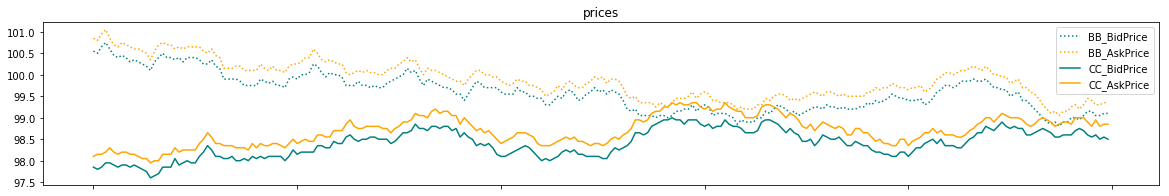

In [18]:
# Quick plot of bid and ask prices of 2 stocks
market_data['BB', 'BidPrice'].iloc[0:250].plot(color='teal', linestyle=':', label = "BB_BidPrice", legend = True)
market_data['BB', 'AskPrice'].iloc[0:250].plot(color='orange', linestyle=':', label = "BB_AskPrice", legend = True)
market_data['CC', 'BidPrice'].iloc[0:250].plot(color='teal', title='prices', figsize=(20, 3),  label = "CC_BidPrice", legend = True)
market_data['CC', 'AskPrice'].iloc[0:250].plot(color='orange', label = "CC_AskPrice", legend = True)


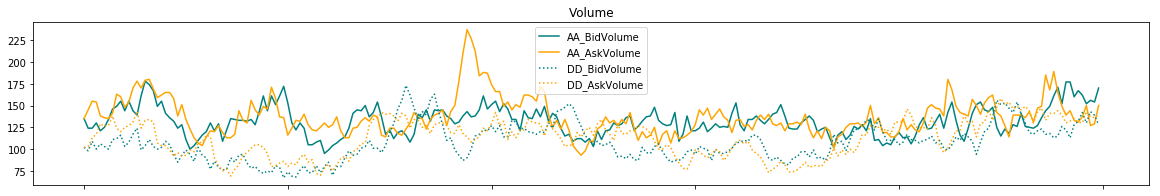

In [19]:
# Quick plot of volume series
market_data['AA', 'BidVolume'].iloc[0:250].plot(color='teal', label = "AA_BidVolume", legend = True, figsize = (20,3))
market_data['AA', 'AskVolume'].iloc[0:250].plot(color='orange', label = "AA_AskVolume", legend = True)
market_data['DD', 'BidVolume'].iloc[0:250].plot(color='teal', linestyle=':', label = "DD_BidVolume", legend = True)
market_data['DD', 'AskVolume'].iloc[0:250].plot(color='orange', title = "Volume", linestyle=':', label = "DD_AskVolume", legend = True)



In [20]:
# Add market mid prices columns

for stock in stock_names:
    market_data[stock,"MidPrice"] = (market_data[stock,'BidPrice'] + market_data[stock, 'AskPrice']) / 2.0
        
        
market_data = market_data.sort_index(axis=1)
market_data.head()        



AA                                             BB  \
                    AskPrice AskVolume BidPrice BidVolume MidPrice AskPrice   
2018-01-01 00:05:00    80.25     135.0    80.00     135.0   80.125   100.85   
2018-01-01 00:10:00    80.20     145.0    79.95     124.0   80.075   100.80   
2018-01-01 00:15:00    80.15     155.0    79.95     124.0   80.050   100.95   
2018-01-01 00:20:00    80.10     154.0    79.95     130.0   80.025   101.05   
2018-01-01 00:25:00    80.10     138.0    79.90     121.0   80.000   100.85   

                                                            ...          NN  \
                    AskVolume BidPrice BidVolume MidPrice   ...    AskPrice   
2018-01-01 00:05:00     105.0   100.55     105.0  100.700   ...      137.60   
2018-01-01 00:10:00     113.0   100.50     104.0  100.650   ...      137.55   
2018-01-01 00:15:00     107.0   100.65     100.0  100.800   ...      137.65   
2018-01-01 00:20:00     109.0   100.75     112.0  100.900   ...      137.65   
2018-01-01 00:25:00     124.0   100.60     126.0  100.725   ...      137.60   

                                                                OO            \
                    AskVolume BidPrice BidVolume MidPrice AskPrice AskVolume   
2018-01-01 00:05:00     122.0   137.20     122.0  137.400    89.05     109.0   
2018-01-01 00:10:00     110.0   137.20     111.0  137.375    89.00     100.0   
2018-01-01 00:15:00     106.0   137.25     117.0  137.450    89.00     100.0   
2018-01-01 00:20:00      97.0   137.25     107.0  137.450    89.00     113.0   
2018-01-01 00:25:00     109.0   137.15     111.0  137.375    89.00     112.0   

                                                 
                    BidPrice BidVolume MidPrice  
2018-01-01 00:05:00    88.80     109.0   88.925  
2018-01-01 00:10:00    88.75     115.0   88.875  
2018-01-01 00:15:00    88.70      92.0   88.850  
2018-01-01 00:20:00    88.75     100.0   88.875  
2018-01-01 00:25:00    88.75      98.0   88.875  

[5 rows x 75 columns]

In [21]:
# Create new columns with log prices, because we want to work with log prices to calculate cointegration
for stock in stock_names:
    market_data[stock,"MidPriceLog"] = np.log(market_data[stock,'MidPrice'])
    market_data[stock,"AskPriceLog"] = np.log(market_data[stock,'AskPrice'])
    market_data[stock,"BidPriceLog"] = np.log(market_data[stock,'BidPrice'])      
        
market_data = market_data.sort_index(axis=1)
market_data.head()        


AA                                             \
                    AskPrice AskPriceLog AskVolume BidPrice BidPriceLog   
2018-01-01 00:05:00    80.25    4.385147     135.0    80.00    4.382027   
2018-01-01 00:10:00    80.20    4.384524     145.0    79.95    4.381401   
2018-01-01 00:15:00    80.15    4.383900     155.0    79.95    4.381401   
2018-01-01 00:20:00    80.10    4.383276     154.0    79.95    4.381401   
2018-01-01 00:25:00    80.10    4.383276     138.0    79.90    4.380776   

                                                         BB              \
                    BidVolume MidPrice MidPriceLog AskPrice AskPriceLog   
2018-01-01 00:05:00     135.0   80.125    4.383588   100.85    4.613634   
2018-01-01 00:10:00     124.0   80.075    4.382964   100.80    4.613138   
2018-01-01 00:15:00     124.0   80.050    4.382651   100.95    4.614625   
2018-01-01 00:20:00     130.0   80.025    4.382339   101.05    4.615615   
2018-01-01 00:25:00     121.0   80.000    4.382027   100.85    4.613634   

                        ...           NN                   OO              \
                        ...     MidPrice MidPriceLog AskPrice AskPriceLog   
2018-01-01 00:05:00     ...      137.400    4.922896    89.05    4.489198   
2018-01-01 00:10:00     ...      137.375    4.922714    89.00    4.488636   
2018-01-01 00:15:00     ...      137.450    4.923260    89.00    4.488636   
2018-01-01 00:20:00     ...      137.450    4.923260    89.00    4.488636   
2018-01-01 00:25:00     ...      137.375    4.922714    89.00    4.488636   

                                                                       \
                    AskVolume BidPrice BidPriceLog BidVolume MidPrice   
2018-01-01 00:05:00     109.0    88.80    4.486387     109.0   88.925   
2018-01-01 00:10:00     100.0    88.75    4.485823     115.0   88.875   
2018-01-01 00:15:00     100.0    88.70    4.485260      92.0   88.850   
2018-01-01 00:20:00     113.0    88.75    4.485823     100.0   88.875   
2018-01-01 00:25:00     112.0    88.75    4.485823      98.0   88.875   

                                 
                    MidPriceLog  
2018-01-01 00:05:00    4.487793  
2018-01-01 00:10:00    4.487231  
2018-01-01 00:15:00    4.486950  
2018-01-01 00:20:00    4.487231  
2018-01-01 00:25:00    4.487231  

[5 rows x 120 columns]

In [22]:
# Create new columns with bid-ask spread, also with log prices and make it a percentage (Vidyamurthy page 83)

for stock in stock_names:
    market_data[stock,"BidAskSpread"] = (market_data[stock,'AskPrice'] - market_data[stock, 'BidPrice'])
    market_data[stock,"BidAskSpreadLogPerc"] = (market_data[stock,'AskPriceLog'] - market_data[stock, 'BidPriceLog']) / market_data[stock, 'AskPriceLog']
    
market_data = market_data.sort_index(axis=1)
market_data.head()     

AA                                     \
                    AskPrice AskPriceLog AskVolume BidAskSpread   
2018-01-01 00:05:00    80.25    4.385147     135.0         0.25   
2018-01-01 00:10:00    80.20    4.384524     145.0         0.25   
2018-01-01 00:15:00    80.15    4.383900     155.0         0.20   
2018-01-01 00:20:00    80.10    4.383276     154.0         0.15   
2018-01-01 00:25:00    80.10    4.383276     138.0         0.20   

                                                                        \
                    BidAskSpreadLogPerc BidPrice BidPriceLog BidVolume   
2018-01-01 00:05:00            0.000712    80.00    4.382027     135.0   
2018-01-01 00:10:00            0.000712    79.95    4.381401     124.0   
2018-01-01 00:15:00            0.000570    79.95    4.381401     124.0   
2018-01-01 00:20:00            0.000428    79.95    4.381401     130.0   
2018-01-01 00:25:00            0.000570    79.90    4.380776     121.0   

                                             ...           OO              \
                    MidPrice MidPriceLog     ...     AskPrice AskPriceLog   
2018-01-01 00:05:00   80.125    4.383588     ...        89.05    4.489198   
2018-01-01 00:10:00   80.075    4.382964     ...        89.00    4.488636   
2018-01-01 00:15:00   80.050    4.382651     ...        89.00    4.488636   
2018-01-01 00:20:00   80.025    4.382339     ...        89.00    4.488636   
2018-01-01 00:25:00   80.000    4.382027     ...        89.00    4.488636   

                                                                         \
                    AskVolume BidAskSpread BidAskSpreadLogPerc BidPrice   
2018-01-01 00:05:00     109.0         0.25            0.000626    88.80   
2018-01-01 00:10:00     100.0         0.25            0.000627    88.75   
2018-01-01 00:15:00     100.0         0.30            0.000752    88.70   
2018-01-01 00:20:00     113.0         0.25            0.000627    88.75   
2018-01-01 00:25:00     112.0         0.25            0.000627    88.75   

                                                                
                    BidPriceLog BidVolume MidPrice MidPriceLog  
2018-01-01 00:05:00    4.486387     109.0   88.925    4.487793  
2018-01-01 00:10:00    4.485823     115.0   88.875    4.487231  
2018-01-01 00:15:00    4.485260      92.0   88.850    4.486950  
2018-01-01 00:20:00    4.485823     100.0   88.875    4.487231  
2018-01-01 00:25:00    4.485823      98.0   88.875    4.487231  

[5 rows x 150 columns]

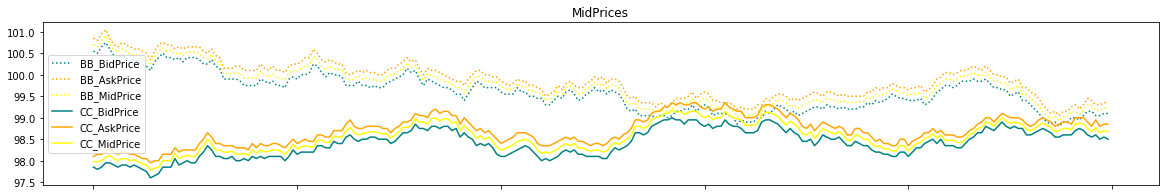

In [23]:
#Visualize mid prices to check if they are correct
market_data['BB', 'BidPrice'].iloc[0:250].plot(color='teal', linestyle=':', label = "BB_BidPrice", legend = True)
market_data['BB', 'AskPrice'].iloc[0:250].plot(color='orange', linestyle=':', label = "BB_AskPrice", legend = True)
market_data['BB', 'MidPrice'].iloc[0:250].plot(color='yellow', linestyle=':', label = "BB_MidPrice", legend = True)
market_data['CC', 'BidPrice'].iloc[0:250].plot(color='teal', title='MidPrices', figsize=(20, 3),  label = "CC_BidPrice", legend = True)
market_data['CC', 'AskPrice'].iloc[0:250].plot(color='orange', label = "CC_AskPrice", legend = True)
market_data['CC', 'MidPrice'].iloc[0:250].plot(color='yellow', label = "CC_MidPrice", legend = True)

In [24]:
# Try analysis functions on BB and CC. Conclusion: not a good pair to trade (high p-value)
print(engle_granger_two_step_cointegration_test(market_data['BB','MidPriceLog'], market_data['CC', 'MidPriceLog']))
estimate_long_run_short_run_relationships(market_data['BB','MidPriceLog'], market_data['CC', 'MidPriceLog'])

(-2.527138880780233, 0.10900999049806837)


(0.7748370081614127,
 0.8293264988000448,
 -0.00021288290316357427,
 2018-01-01 00:05:00    0.035085
 2018-01-01 00:10:00    0.034589
 2018-01-01 00:15:00    0.035866
 2018-01-01 00:20:00    0.036223
 2018-01-01 00:25:00    0.034065
 2018-01-01 00:30:00    0.033209
 2018-01-01 00:35:00    0.033134
 2018-01-01 00:40:00    0.033457
 2018-01-01 00:45:00    0.032960
 2018-01-01 00:50:00    0.032637
 2018-01-01 00:55:00    0.032425
 2018-01-01 01:00:00    0.032600
 2018-01-01 01:05:00    0.032525
 2018-01-01 01:10:00    0.032239
 2018-01-01 01:15:00    0.032052
 2018-01-01 01:20:00    0.033621
 2018-01-01 01:25:00    0.034653
 2018-01-01 01:30:00    0.034129
 2018-01-01 01:35:00    0.033383
 2018-01-01 01:40:00    0.033383
 2018-01-01 01:45:00    0.031157
 2018-01-01 01:50:00    0.032711
 2018-01-01 01:55:00    0.031542
 2018-01-01 02:00:00    0.032077
 2018-01-01 02:05:00    0.032289
 2018-01-01 02:10:00    0.032289
 2018-01-01 02:15:00    0.030773
 2018-01-01 02:20:00    0.028934
 2018-01

In [25]:
# Run the analysis functions for all pairs by creating a nested loop and storing them in dictionaries
stock_names_duplicate = list(market_data.columns.get_level_values(0).unique())

dict_pvalue = {}
dict_dstat = {}
dict_c = {}
dict_gamma = {}
dict_alpha = {}
dict_z = {}


for stock in stock_names:
    for stockduplicate in stock_names_duplicate:
        if stock != stockduplicate and (stockduplicate, stock) not in dict_pvalue:
            dict_pvalue[(stock, stockduplicate)] = engle_granger_two_step_cointegration_test(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[1]
            dict_dstat[(stock, stockduplicate)] = engle_granger_two_step_cointegration_test(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[0]
            dict_c[(stock, stockduplicate)] = estimate_long_run_short_run_relationships(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[0]
            dict_gamma[(stock, stockduplicate)] = estimate_long_run_short_run_relationships(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[1]
            dict_alpha[(stock, stockduplicate)] = estimate_long_run_short_run_relationships(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[2]
            dict_z[(stock, stockduplicate)] = estimate_long_run_short_run_relationships(market_data[stock,'MidPriceLog'], market_data[stockduplicate, 'MidPriceLog'])[3]

In [26]:
# Create dataframes with pvalues and test statistics, as well as long run short run relationship
pvalues_df = pd.DataFrame.from_dict(dict_pvalue, orient='index')
pvalues_df.rename(columns = {0: 'p_value'}, inplace = True)
print(pvalues_df.head())

dstat_df = pd.DataFrame.from_dict(dict_dstat, orient='index')
dstat_df.rename(columns = {0: 'd_stat'}, inplace = True)
dstat_df.head()

c_df = pd.DataFrame.from_dict(dict_c, orient='index')
c_df.rename(columns = {0: 'c_value'}, inplace = True)
print(c_df.head())

gamma_df = pd.DataFrame.from_dict(dict_gamma, orient='index')
gamma_df.rename(columns = {0: 'gamma_value'}, inplace = True)
print(gamma_df.head())

alpha_df = pd.DataFrame.from_dict(dict_alpha, orient='index')
alpha_df.rename(columns = {0: 'alpha_value'}, inplace = True)
print(alpha_df.head())

z_df = pd.DataFrame.from_dict(dict_z, orient='index')
z_df.rename(columns = {0: 'z_value'}, inplace = True)
z_df.head()

           p_value
(AA, BB)  0.573940
(AA, CC)  0.920701
(AA, DD)  0.610321
(AA, EE)  0.218617
(AA, FF)  0.468741
            c_value
(AA, BB)   4.208162
(AA, CC)   6.414322
(AA, DD)   4.212532
(AA, EE)  15.025244
(AA, FF)  10.628626
          gamma_value
(AA, BB)     0.057084
(AA, CC)    -0.430848
(AA, DD)     0.053972
(AA, EE)    -2.150272
(AA, FF)    -1.320618
          alpha_value
(AA, BB)    -0.000121
(AA, CC)    -0.000126
(AA, DD)    -0.000123
(AA, EE)    -0.000302
(AA, FF)    -0.000167


2018-01-01 00:05:00  2018-01-01 00:10:00  2018-01-01 00:15:00  \
AA BB            -0.087856            -0.088452            -0.088849   
   CC            -0.055417            -0.056042            -0.056244   
   DD            -0.086024            -0.086637            -0.086926   
   EE            -0.040495            -0.039954            -0.039879   
   FF            -0.018427            -0.018459            -0.017885   

       2018-01-01 00:20:00  2018-01-01 00:25:00  2018-01-01 00:30:00  \
AA BB            -0.089218            -0.089431            -0.089971   
   CC            -0.056227            -0.056320            -0.057274   
   DD            -0.087273            -0.087585            -0.088234   
   EE            -0.040967            -0.042056            -0.043070   
   FF            -0.017606            -0.017919            -0.017658   

       2018-01-01 00:35:00  2018-01-01 00:40:00  2018-01-01 00:45:00  \
AA BB            -0.089318            -0.089360            -0.088707   
   CC            -0.056869            -0.056649            -0.056024   
   DD            -0.087608            -0.087585            -0.086984   
   EE            -0.042445            -0.042445            -0.041820   
   FF            -0.016738            -0.017033            -0.016113   

       2018-01-01 00:50:00         ...           2018-02-28 23:10:00  \
AA BB            -0.088664         ...                      0.063317   
   CC            -0.056244         ...                      0.086632   
   DD            -0.086984         ...                      0.064409   
   EE            -0.041043         ...                      0.033286   
   FF            -0.015818         ...                      0.055502   

       2018-02-28 23:15:00  2018-02-28 23:20:00  2018-02-28 23:25:00  \
AA BB             0.063884             0.063959             0.064437   
   CC             0.087282             0.087058             0.087596   
   DD             0.064911             0.064982             0.065556   
   EE             0.033019             0.032617             0.033959   
   FF             0.057291             0.058542             0.058767   

       2018-02-28 23:30:00  2018-02-28 23:35:00  2018-02-28 23:40:00  \
AA BB             0.064735             0.063959             0.063959   
   CC             0.088088             0.087170             0.087839   
   DD             0.065860             0.065066             0.065066   
   EE             0.034630             0.033421             0.034225   
   FF             0.059348             0.059479             0.059791   

       2018-02-28 23:45:00  2018-02-28 23:50:00  2018-02-28 23:55:00  
AA BB             0.063152             0.062315             0.063421  
   CC             0.087032             0.085890             0.087747  
   DD             0.064283             0.063476             0.064588  
   EE             0.033017             0.032611             0.033688  
   FF             0.058360             0.057552             0.057691  

[5 rows x 16991 columns]

In [27]:
# Inspect z dataframe
error_df=z_df.T
error_df.head()

AA                                          \
                           BB        CC        DD        EE        FF   
2018-01-01 00:05:00 -0.087856 -0.055417 -0.086024 -0.040495 -0.018427   
2018-01-01 00:10:00 -0.088452 -0.056042 -0.086637 -0.039954 -0.018459   
2018-01-01 00:15:00 -0.088849 -0.056244 -0.086926 -0.039879 -0.017885   
2018-01-01 00:20:00 -0.089218 -0.056227 -0.087273 -0.040967 -0.017606   
2018-01-01 00:25:00 -0.089431 -0.056320 -0.087585 -0.042056 -0.017919   

                                                                       \
                           GG        HH        II        JJ        KK   
2018-01-01 00:05:00 -0.009852 -0.090073 -0.063167 -0.087357 -0.009584   
2018-01-01 00:10:00 -0.010256 -0.090620 -0.062007 -0.087933 -0.010697   
2018-01-01 00:15:00 -0.010347 -0.090932 -0.062319 -0.088148 -0.011742   
2018-01-01 00:20:00 -0.010439 -0.091219 -0.064416 -0.088485 -0.010345   
2018-01-01 00:25:00 -0.010972 -0.091506 -0.065025 -0.088797 -0.009682   

                       ...           KK                                \
                       ...           LL        MM        NN        OO   
2018-01-01 00:05:00    ...     0.065346  0.039312  0.036637  0.043131   
2018-01-01 00:10:00    ...     0.064850  0.038877  0.036360  0.042279   
2018-01-01 00:15:00    ...     0.064198  0.037944  0.035236  0.041418   
2018-01-01 00:20:00    ...     0.065719  0.039325  0.036758  0.043148   
2018-01-01 00:25:00    ...     0.066771  0.040475  0.038097  0.044017   

                           LL                            MM            \
                           MM        NN        OO        NN        OO   
2018-01-01 00:05:00 -0.001604  0.000610  0.005821 -0.001675  0.029983   
2018-01-01 00:10:00 -0.001832  0.000381  0.005693 -0.001399  0.029633   
2018-01-01 00:15:00 -0.001855  0.000382  0.005743 -0.001701  0.029984   
2018-01-01 00:20:00 -0.001866  0.000382  0.005693 -0.001438  0.030422   
2018-01-01 00:25:00 -0.001158  0.001066  0.006379 -0.001136  0.029896   

                           NN  
                           OO  
2018-01-01 00:05:00  0.021661  
2018-01-01 00:10:00  0.021263  
2018-01-01 00:15:00  0.021700  
2018-01-01 00:20:00  0.021808  
2018-01-01 00:25:00  0.021263  

[5 rows x 105 columns]

In [28]:
# Sort pvalues (lower is better)
pvalues_df.sort_values(by = "p_value", inplace = True)
pvalues_df.head(10)

,p_value
"(FF, MM)",7.728683e-30
"(BB, JJ)",7.771578e-30
"(FF, NN)",4.568689e-13
"(BB, DD)",4.742349e-11
"(MM, NN)",6.668338e-11
"(DD, JJ)",2.530147e-09
"(DD, HH)",5.898042e-06
"(BB, HH)",9.048330e-04
"(HH, JJ)",1.032436e-03
"(AA, II)",3.106972e-03


In [29]:
# Sort dickey fuller statistic (more negative is better)
dstat_df.sort_values(by = "d_stat", inplace = True)
dstat_df.head(10)

,d_stat
"(FF, MM)",-17.079157
"(BB, JJ)",-17.075528
"(FF, NN)",-8.279180
"(BB, DD)",-7.482111
"(MM, NN)",-7.422785
"(DD, JJ)",-6.778814
"(DD, HH)",-5.284403
"(BB, HH)",-4.117834
"(HH, JJ)",-4.083176
"(AA, II)",-3.781076


In [30]:
# Sort alpha values (higher absolute value is better), 
# these together with p-value and dickey fuller statistic determine the right pairs to trade
alpha_df.sort_values(by = "alpha_value", inplace = True)
alpha_df.head(10)

,alpha_value
"(FF, MM)",-0.033801
"(BB, DD)",-0.007537
"(DD, HH)",-0.003964
"(BB, HH)",-0.002434
"(FF, NN)",-0.002220
"(KK, NN)",-0.001064
"(KK, MM)",-0.000991
"(KK, OO)",-0.000912
"(EE, GG)",-0.000813
"(CC, JJ)",-0.000813


In [31]:
#
c_df.sort_values(by = "c_value", inplace = True)
c_df.head(10)

,c_value
"(GG, NN)",-6.100375
"(BB, HH)",-4.818090
"(CC, NN)",-3.573628
"(AA, OO)",-3.365546
"(MM, NN)",-2.903375
"(FF, NN)",-2.610379
"(BB, JJ)",-2.480883
"(BB, DD)",-2.418202
"(CC, HH)",-1.976781
"(DD, HH)",-1.679735


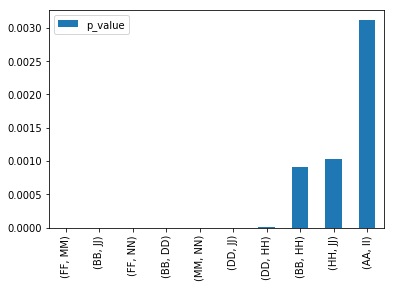

In [32]:
# Best pairs to trade according to p-value
# Conclusion: (FF,MM) (BB, JJ), (FF,NN), (BB, DD), (MM, NN), (DD, JJ), (DD, HH) are all below 0.0001

pvalues_df.head(10).plot(kind = "bar")

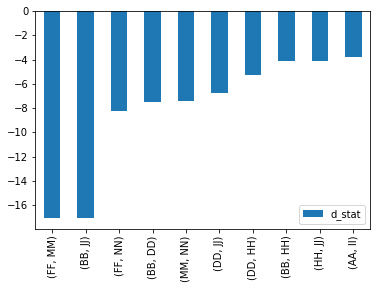

In [33]:
# Best pairs to trade according to dstat
dstat_df.head(10).plot(kind = "bar")

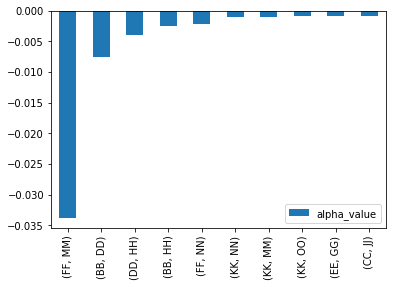

In [34]:
# Best pairs to trade according to alpha
alpha_df.head(10).plot(kind = "bar")

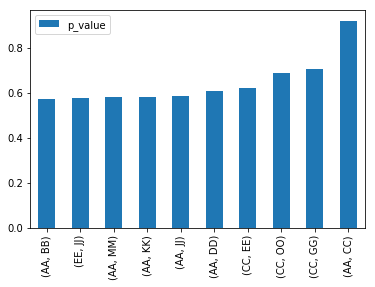

In [35]:
# Worst pairs according to p-value
pvalues_df.tail(10).plot(kind = "bar")

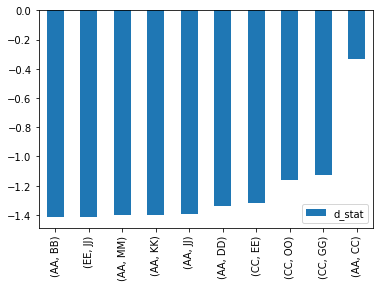

In [36]:
# Worst pairs to trade according to dstat
dstat_df.tail(10).plot(kind = "bar")

In [37]:
# Create a copy as a fail safe
market_data_copy = market_data.copy()

In [38]:
# Merge market data and the z (error correction term) dataframe
market_data = pd.merge(market_data,error_df,left_index=True, right_index=True )
market_data = market_data.sort_index(axis=1)
market_data.head() 

AA                                               \
                    AskPrice AskPriceLog AskVolume        BB BidAskSpread   
2018-01-01 00:05:00    80.25    4.385147     135.0 -0.087856         0.25   
2018-01-01 00:10:00    80.20    4.384524     145.0 -0.088452         0.25   
2018-01-01 00:15:00    80.15    4.383900     155.0 -0.088849         0.20   
2018-01-01 00:20:00    80.10    4.383276     154.0 -0.089218         0.15   
2018-01-01 00:25:00    80.10    4.383276     138.0 -0.089431         0.20   

                                                                        \
                    BidAskSpreadLogPerc BidPrice BidPriceLog BidVolume   
2018-01-01 00:05:00            0.000712    80.00    4.382027     135.0   
2018-01-01 00:10:00            0.000712    79.95    4.381401     124.0   
2018-01-01 00:15:00            0.000570    79.95    4.381401     124.0   
2018-01-01 00:20:00            0.000428    79.95    4.381401     130.0   
2018-01-01 00:25:00            0.000570    79.90    4.380776     121.0   

                                  ...           OO                        \
                           CC     ...     AskPrice AskPriceLog AskVolume   
2018-01-01 00:05:00 -0.055417     ...        89.05    4.489198     109.0   
2018-01-01 00:10:00 -0.056042     ...        89.00    4.488636     100.0   
2018-01-01 00:15:00 -0.056244     ...        89.00    4.488636     100.0   
2018-01-01 00:20:00 -0.056227     ...        89.00    4.488636     113.0   
2018-01-01 00:25:00 -0.056320     ...        89.00    4.488636     112.0   

                                                                           \
                    BidAskSpread BidAskSpreadLogPerc BidPrice BidPriceLog   
2018-01-01 00:05:00         0.25            0.000626    88.80    4.486387   
2018-01-01 00:10:00         0.25            0.000627    88.75    4.485823   
2018-01-01 00:15:00         0.30            0.000752    88.70    4.485260   
2018-01-01 00:20:00         0.25            0.000627    88.75    4.485823   
2018-01-01 00:25:00         0.25            0.000627    88.75    4.485823   

                                                    
                    BidVolume MidPrice MidPriceLog  
2018-01-01 00:05:00     109.0   88.925    4.487793  
2018-01-01 00:10:00     115.0   88.875    4.487231  
2018-01-01 00:15:00      92.0   88.850    4.486950  
2018-01-01 00:20:00     100.0   88.875    4.487231  
2018-01-01 00:25:00      98.0   88.875    4.487231  

[5 rows x 255 columns]

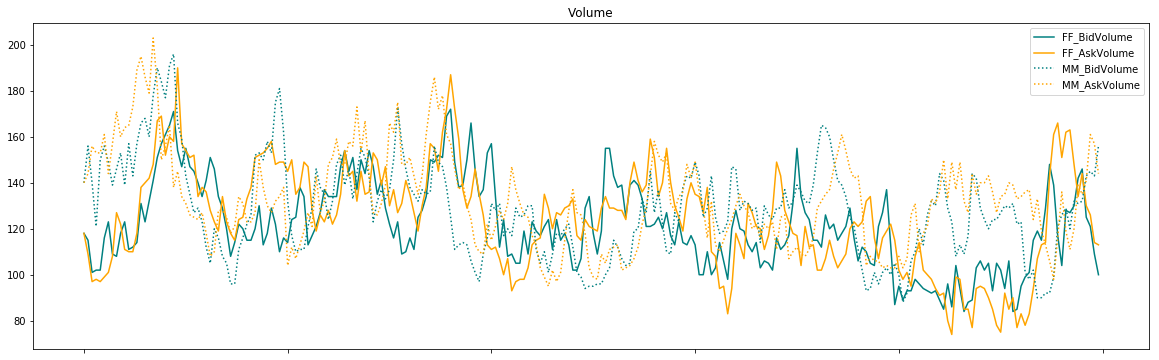

In [39]:
# Visualize bid and ask volume

# Plot of volume series
market_data['FF', 'BidVolume'].iloc[0:250].plot(color='teal', label = "FF_BidVolume", legend = True, figsize = (20,6))
market_data['FF', 'AskVolume'].iloc[0:250].plot(color='orange', label = "FF_AskVolume", legend = True)
market_data['MM', 'BidVolume'].iloc[0:250].plot(color='teal', linestyle=':', label = "MM_BidVolume", legend = True)
market_data['MM', 'AskVolume'].iloc[0:250].plot(color='orange', title = "Volume", linestyle=':', label = "MM_AskVolume", legend = True)


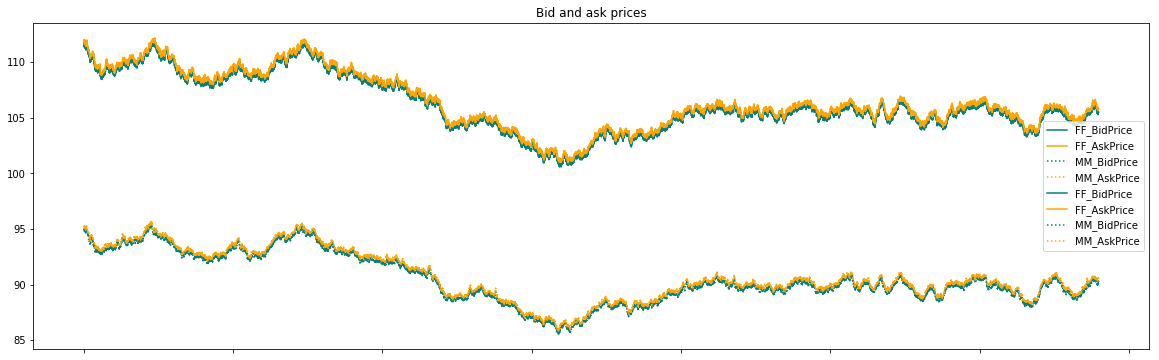

In [40]:
# Visualize bid and ask prices
market_data['FF', 'BidPrice'].plot(color='teal', label = "FF_BidPrice", legend = True, figsize = (20,6))
market_data['FF', 'AskPrice'].plot(color='orange', label = "FF_AskPrice", legend = True)
market_data['MM', 'BidPrice'].plot(color='teal', linestyle=':', label = "MM_BidPrice", legend = True)
market_data['MM', 'AskPrice'].plot(color='orange', title = "Bid and ask prices", linestyle=':', label = "MM_AskPrice", legend = True)

market_data['FF', 'BidPrice'].plot(color='teal', label = "FF_BidPrice", legend = True, figsize = (20,6))
market_data['FF', 'AskPrice'].plot(color='orange', label = "FF_AskPrice", legend = True)
market_data['MM', 'BidPrice'].plot(color='teal', linestyle=':', label = "MM_BidPrice", legend = True)
market_data['MM', 'AskPrice'].plot(color='orange', title = "Bid and ask prices", linestyle=':', label = "MM_AskPrice", legend = True)


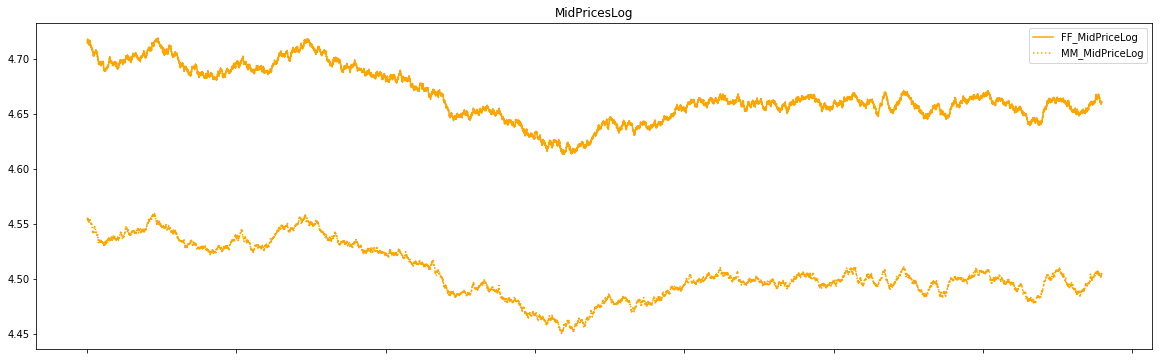

In [41]:
# Visualize log of mid prices (just like bid-ask graph, cointegration is easily spotted here)
market_data['FF', 'MidPriceLog'].plot(color='orange', label = "FF_MidPriceLog", legend = True, figsize = (20,6))
market_data['MM', 'MidPriceLog'].plot(color='orange', title = "MidPricesLog", linestyle=':', label = "MM_MidPriceLog", legend = True)

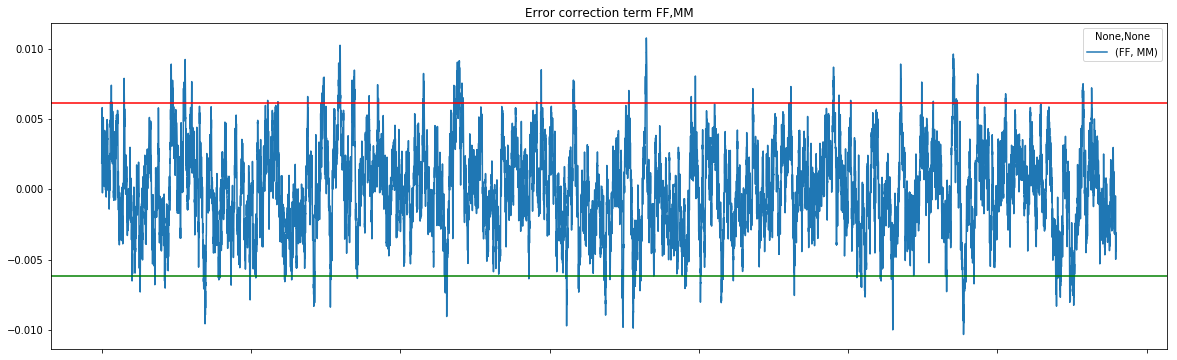

In [42]:
# Visualize error correction term with lines at 2 * standard deviation (theoretical optimal z)

# Calculate standard deviation of Z, optimal threshold is 2 * standard deviation
#(paper: Pairs trading: optimal thresholds and profitability) -> trade below 2 standard deviation would be a trade of poor quality

optimal_z = market_data['FF', 'MM'].std() * 2
optimal_z

market_data.plot(y = [('FF', 'MM')], title = 'Error correction term FF,MM', figsize = (20,6))
plt.pyplot.axhline(y = optimal_z, color = 'r')
plt.pyplot.axhline(y = -optimal_z, color = 'g')

In [43]:
# Get maximum and minimum values of error correction term
print(market_data['FF', 'MM'].idxmax())
print(max(market_data['FF', 'MM']))
print(market_data['FF', 'MM'].idxmin())
print(min(market_data['FF', 'MM']))

2018-02-01 16:10:00
0.010773246778821743
2018-02-20 02:50:00
-0.010334524487920937


In [44]:
# Inspect FF,MM pair. Conclusion: if error correction term is high, sell the spread -> sell FF, buy MM
# if the error correction term is low, buy the spread -> buy FF, sell MM
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

time_max = '2018-02-01 16:10:00'

max_MidPrice_FF_at_time = market_data.loc[time_max, ('FF', 'MidPrice')]
max_MidPrice_MM_at_time = market_data.loc[time_max, ('MM', 'MidPrice')]
print('Max price FF is',max_MidPrice_FF_at_time, 'Max price MM is', max_MidPrice_MM_at_time)

time_min = '2018-02-20 02:50:00'

min_MidPrice_FF_at_time = market_data.loc[time_min, ('FF', 'MidPrice')]
min_MidPrice_MM_at_time = market_data.loc[time_min, ('MM', 'MidPrice')]
print('Min price FF is', min_MidPrice_FF_at_time, 'Min price MM is', min_MidPrice_MM_at_time)

Max price FF is 103.675 Max price MM is 87.275
Min price FF is 104.35 Min price MM is 89.80000000000001


In [45]:
# Make a dataframe with the relationship coefficients (c, gamma, alpha, p-value, dickey fuller statistic)
rel_coeff = pd.merge(c_df, gamma_df,left_index=True, right_index=True )
rel_coeff = pd.merge(rel_coeff, alpha_df,left_index=True, right_index=True )
rel_coeff = pd.merge(rel_coeff, pvalues_df,left_index=True, right_index=True )
rel_coeff = pd.merge(rel_coeff, dstat_df,left_index=True, right_index=True )
rel_coeff = rel_coeff.copy()
rel_coeff.head()


,c_value,gamma_value,alpha_value,p_value,d_stat
"(GG, NN)",-6.100375,2.305404,-0.000284,3.442840e-01,-1.874221
"(BB, HH)",-4.818090,1.871188,-0.002434,9.048330e-04,-4.117834
"(CC, NN)",-3.573628,1.655427,-0.000163,3.586701e-01,-1.844362
"(AA, OO)",-3.365546,1.733681,-0.000080,3.276423e-01,-1.909421
"(MM, NN)",-2.903375,1.515257,-0.000170,6.668338e-11,-7.422785


In [67]:
# Determine optimal pairs basede on p-value, alpha and dickey fuller statistic
# We want a p_value below 0.0001, an alpha below 0.002 and a dickey fuller statistic below 6

pairs_traded = rel_coeff.loc[rel_coeff["p_value"] < 0.0001].loc[abs(rel_coeff["alpha_value"]) > 0.002].loc[abs(rel_coeff["d_stat"]) > 6]
pairs = list(pairs_traded.T.columns.get_level_values(0).unique())

for pair in pairs:
    print(rel_coeff.loc[[pair],:])
    
pairs

           c_value  gamma_value  alpha_value       p_value   d_stat
(FF, NN) -2.610379  1.488106    -0.00222      4.568689e-13 -8.27918
           c_value  gamma_value  alpha_value       p_value    d_stat
(BB, DD) -2.418202  1.475791    -0.007537     4.742349e-11 -7.482111
           c_value  gamma_value  alpha_value       p_value     d_stat
(FF, MM)  0.306135  0.967619    -0.033801     7.728683e-30 -17.079157


[('FF', 'NN'), ('BB', 'DD'), ('FF', 'MM')]

In [68]:
# Create a list with the individual stocks in our optimal pairs
stocks=[]
for pair in pairs:
    for stock in pair:
        if stock not in stocks:
            stocks.append(stock)
            
stocks

['FF', 'NN', 'BB', 'DD', 'MM']

In [52]:
# Create a function that checks if a number is whole
def is_whole(n):
    return n % 1 == 0

print(is_whole(4.5), is_whole(10))

False True


# Algorithm 

In [53]:
### Algorithm ### 
limit = 100

# Positions dataframe, the initial values are all 0.          
positions = pd.DataFrame(data=0, 
                         index=market_data.index,
                         columns= stocks)       

for time, mkt_data_at_time in market_data.iterrows():
    if prev_time == None:
        # This skips the first observation, we don't want to take a position yet
        prev_time = time
        continue


    # Loop over each pair and consecutive timestamp in the DataFrame and make a trading decision at each timestamp, 
    # dynamically keeping track of the previous timestamp to easily refer to the previous positions.
    # Because our algorithm only works for the pairs individually but not all together, this output is for one pair
    for pair in pairs:
        stock1=pair[0]
        stock2=pair[1]

        # Trade ratio is 1:(gamma * y_t-1 / x_t-1)
        gamma = rel_coeff.loc[[pair], 'gamma_value']
        gamma = gamma.iloc[0]
        previous_price_stock1 = market_data.loc[prev_time, (stock1, 'MidPrice')]
        previous_price_stock2 = market_data.loc[prev_time, (stock2, 'MidPrice')]
        
        trade_ratio = gamma* previous_price_stock1/previous_price_stock2
        optimal_z = market_data[stock1, stock2].std() * 2
        
        # If the error correction term is higher than 0.005:
        if mkt_data_at_time[stock1, stock2] > optimal_z:

            # Check if trade is feasible with trading slippage (Vidyamurthy book, page 83)
            # If trading slippage < optimal z, the trade is feasible
            if (mkt_data_at_time[stock1, 'BidAskSpreadLogPerc'] + trade_ratio * mkt_data_at_time[stock2, 'BidAskSpreadLogPerc']) < optimal_z:

            # Then sell the spread -> sell FF and buy MM.
            # But never trade more than the volume available on either side.
                volume_available = min(mkt_data_at_time[stock1, 'BidVolume'], 
                                       mkt_data_at_time[stock2, 'AskVolume'])

                previous_position_stock1 = positions.loc[prev_time, stock1]
                previous_position_stock2 = positions.loc[prev_time, stock2]
                
            # Sell stock1 and buy stock 2, so for stock1 the ideal position is -volume available and vice versa
                ideal_position_stock1 = previous_position_stock1 - volume_available 
                ideal_position_stock2 = previous_position_stock2 + volume_available 

            # We would like to trade up to ideal_position, but 
            # if that is more than the limit of one of the stocks, we will trade up to the limit instead
                limited_position_stock1 = max(ideal_position_stock1, -limit)
                limited_position_stock2 = min(ideal_position_stock2, limit)
                
            # To stay within our limit, we calculate the lowest absolute limited position of the pair,
            # using the previous position and the limited difference between the previous positions
            # and the limited positions
                limited_difference_stock1 = limited_position_stock1 - previous_position_stock1
                limited_difference_stock2 = limited_position_stock2 - previous_position_stock2
                
                limited_position = min(abs(limited_difference_stock1), abs(limited_difference_stock2))

    # Execute the trade
            # If the trade ratio > 1, we need to trade less of stock1 to stay within our limit. So, we divide
            # the initial position by the trade ratio to get a smaller number of stocks. We also use math.floor to 
            # get whole values (we can only trade whole units). 
                if  trade_ratio > 1:
                    stock1P = math.floor(previous_position_stock1-limited_position/trade_ratio)
                    stock2P = math.floor(previous_position_stock2+limited_position)
                    
                # Since we sell stock1, the new position should be lower than the previous position
                    if stock1P < positions.loc[prev_time, stock1]:
                        positions.loc[time, stock1] = stock1P
                        positions.loc[time, stock2] = stock2P
                # If this is not the case, we keep the previous position
                    else:
                        positions.loc[time, stock1] = positions.loc[prev_time, stock1]
                        positions.loc[time, stock2] = positions.loc[prev_time, stock2]
            # If the trade ratio < 1, we can trade at the limited position. So, the position of stock1 is 
            # previous position -limited position (sell) and the position of stock2 is
            # previous position + limited position (buy) * trade_ratio
            # We also use math.floor to get whole values (we can only trade whole units).                       
                else:
                    stock1P = math.floor(previous_position_stock1 - limited_position)
                    stock2P = math.floor(previous_position_stock2 + limited_position * trade_ratio)
                    if stock1P < positions.loc[prev_time, stock1]:
                        positions.loc[time, stock1] = stock1P
                        positions.loc[time, stock2] = stock2P
                    else:
                        positions.loc[time, stock1] = positions.loc[prev_time, stock1]
                        positions.loc[time, stock2] = positions.loc[prev_time, stock2]

        # Else buy the spread -> buy FF and sell MM
        elif mkt_data_at_time[stock1, stock2] < -optimal_z:

            # Check if trade is feasible with trading slippage (Vidyamurthy book, page 83)
            # If trading slippage < absolute value of optimal z, the trade is feasible
            if (mkt_data_at_time[stock1, 'BidAskSpreadLogPerc'] + trade_ratio * mkt_data_at_time[stock2, 'BidAskSpreadLogPerc']) < abs(optimal_z):

                # But never trade more than the volume available on either side.
                volume_available = min(mkt_data_at_time[stock1, 'AskVolume'], 
                                       mkt_data_at_time[stock2, 'BidVolume'])

                previous_position_stock1 = positions.loc[prev_time, stock1]
                previous_position_stock2 = positions.loc[prev_time, stock2]
                
            # Sell stock1 and buy stock 2, so for stock1 the ideal position is -volume available and vice versa
                ideal_position_stock1 = previous_position_stock1 + volume_available 
                ideal_position_stock2 = previous_position_stock2 - volume_available 

            # We would like to trade up to ideal_position, but 
            # if that is more than the limit of one of the stocks, we will trade up to the limit instead
                limited_position_stock1 = min(ideal_position_stock1, limit)
                limited_position_stock2 = max(ideal_position_stock2, -limit)
                
            # To stay within our limit, we calculate the lowest absolute limited position of the pair,
            # using the previous position and the limited difference between the previous positions
            # and the limited positions                
                limited_difference_stock1 = limited_position_stock1 - previous_position_stock1
                limited_difference_stock2 = limited_position_stock2 - previous_position_stock2
                
                limited_position = min(abs(limited_difference_stock1), abs(limited_difference_stock2))

        #Execute the trade
             # If the trade ratio > 1, we need to trade less of stock1 to stay within our limit. So, we divide
             # the initial position by the trade ratio to get a smaller number of stocks. We also use math.floor to 
             # get whole values (we can only trade whole units).               
                if trade_ratio > 1: 
                    stock1P = math.floor(previous_position_stock1+limited_position/trade_ratio)
                    stock2P = math.floor(previous_position_stock2-limited_position)
                    
                # Since we buy stock1, the new position should be higher than the previous position                    
                    if stock1P > positions.loc[prev_time, stock1]:
                        positions.loc[time, stock1] = stock1P
                        positions.loc[time, stock2] = stock2P
                # If this is not the case, we keep the previous position                        
                    else:
                        positions.loc[time, stock1] = positions.loc[prev_time, stock1]
                        positions.loc[time, stock2] = positions.loc[prev_time, stock2]
            # If the trade ratio < 1, we can trade at the limited position. So, the position of stock1 is 
            # previous position +limited position (bu) and the position of stock2 is
            # previous position - limited position (sell) * trade_ratio
            # We also use math.floor to get whole values (we can only trade whole units).                          
                else:
                    stock1P = math.floor(previous_position_stock1 + limited_position)
                    stock2P = math.floor(previous_position_stock2 - limited_position * trade_ratio)

                    if stock1P > positions.loc[prev_time, stock1]:
                        positions.loc[time, stock1] = stock1P
                        positions.loc[time, stock2] = stock2P
                    else:
                        positions.loc[time, stock1] = positions.loc[prev_time, stock1]
                        positions.loc[time, stock2] = positions.loc[prev_time, stock2]

        # Or finally, if the error correction term is not above or below the optimal z
        else:
            # Hold the previous positions, no trades
            positions.loc[time, stock1] = positions.loc[prev_time, stock1]
            positions.loc[time, stock2] = positions.loc[prev_time, stock2]

        # In the next iteration of the loop, the previous time will be what is now the current time
        prev_time = time
    

In [54]:
# Inspect positions for each stock at timestamps
positions.tail()

,FF,MM
2018-02-28 23:35:00,-92,100
2018-02-28 23:40:00,-92,100
2018-02-28 23:45:00,-92,100
2018-02-28 23:50:00,-92,100
2018-02-28 23:55:00,-92,100


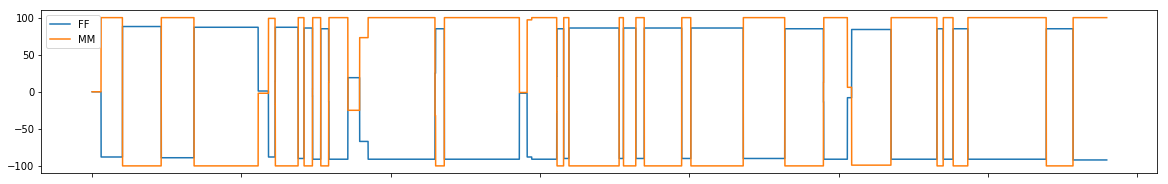

In [55]:
# Visualize positions over time
positions.plot(figsize=(20, 3))

In [56]:
# Traded lots, assume we trade 0 in the first period
trades = positions.diff().fillna(0)

# Again start with an empty DataFrame
pnl_trades = pd.DataFrame(index = trades.index, columns = stocks)


# Calculate total PnL made from trading (we bought against ask price, and sold against bid price).
lots_bought = np.maximum(trades, 0)
lots_sold = -np.minimum(trades, 0)

for stock in stocks:
    pnl_trades[stock] = lots_sold[stock] * market_data[stock, 'BidPrice'] - lots_bought[stock] * market_data[stock, 'AskPrice']

pnl_trades_total = pnl_trades.iloc[:,:].sum(axis=1)
pnl_trades_cumulative = pnl_trades_total.cumsum()

In [57]:
# Evaluating the position at current midprice per stock
position_valuation = pd.DataFrame(data = 0, index = trades.index, columns = stocks)

for stock in stocks:
    position_valuation[stock] = market_data[stock, 'MidPrice'] * positions[stock]

position_valuation_total = position_valuation.iloc[:,:].sum(axis=1)

position_valuation_total.tail()

2018-02-28 23:35:00   -686.5
2018-02-28 23:40:00   -683.8
2018-02-28 23:45:00   -686.7
2018-02-28 23:50:00   -684.2
2018-02-28 23:55:00   -679.8
dtype: float64

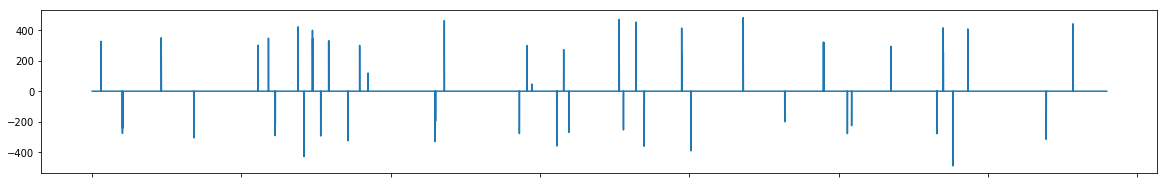

In [58]:
# Total pnl from trades and position
pnl_total = pnl_trades_cumulative + position_valuation_total

# Plot it
pnl_trades_total.plot(figsize=(20, 3))

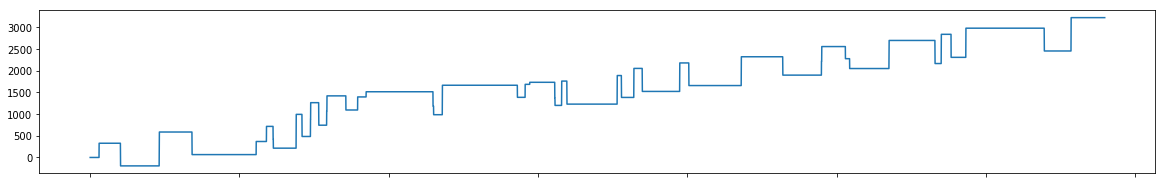

In [59]:
# Visualize cumulative profit and loss
pnl_trades_cumulative.plot(figsize=(20, 3))

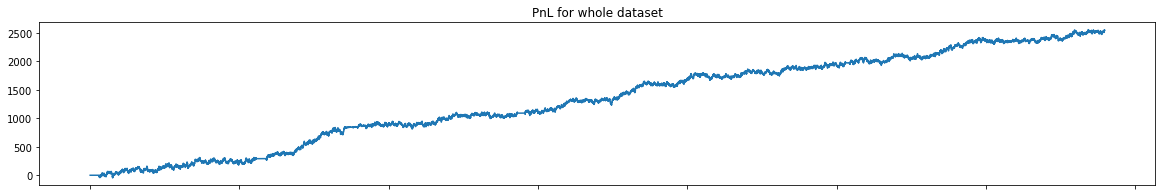

In [60]:
# Visualize total pnl

pnl_total.plot(figsize=(20, 3), title='PnL for whole dataset')

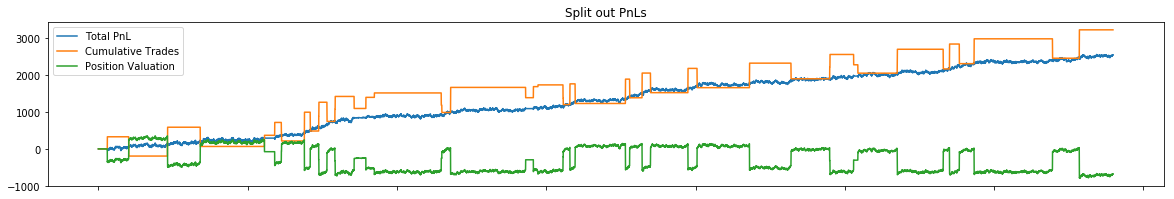

In [61]:
pnl_total.plot(label='Total PnL', 
                            figsize=(20, 3), 
                            title='Split out PnLs', 
                            legend=True)

pnl_trades_cumulative.plot(label='Cumulative Trades', 
                                        legend=True)

position_valuation_total.plot(label='Position Valuation', 
                                           legend=True)

In [62]:
# Create output dataframe with positions and the PnL
output = pd.concat((positions, pnl_total), axis=1)
output.columns.values[[-1]] = ['Profit-and-Loss']
output.tail()

,FF,MM,Profit-and-Loss
2018-02-28 23:35:00,-92,100,2538.1
2018-02-28 23:40:00,-92,100,2540.8
2018-02-28 23:45:00,-92,100,2537.9
2018-02-28 23:50:00,-92,100,2540.4
2018-02-28 23:55:00,-92,100,2544.8


In [63]:
# Create CSV output file 
output.to_csv("PnL.csv")

In [64]:
# For loop to check if (trade ratio * some unit of stocks, up until maximum volume) is a whole number that we can trade,
# so that we preserve our trade ratio
# the optimal FF and MM will be 41 and 46, since these are whole numbers and close to our trade ratio of 1.122525
# (46/41) = 1.122
trade_ratio = 1.122525
limited_position = 50

if (trade_ratio * limited_position) > limited_position:
    FF = math.floor(-limited_position / trade_ratio)
    MM = math.floor(limited_position / trade_ratio) * trade_ratio
    for i in reversed(range(1, abs(FF))):
        if is_whole((i * trade_ratio)): 
            FF = i
            MM = i * trade_ratio
            break
        elif is_whole(round(i * trade_ratio, 1)):
            FF = i
            MM = round(i * trade_ratio, 1)
            break
        elif is_whole(i * round(trade_ratio, 1)):
            FF = i
            MM = (i * round(trade_ratio, 1))
            break
        else:
            FF = 0
            MM = 0
    print("If we go from" ,limited_position, "to 1", " the whole number", FF,
          "times", trade_ratio, "is closest to", MM)  

If we go from 50 to 1  the whole number 41 times 1.122525 is closest to 46.0


In [65]:
# We tried to put it in this function, but it did not work in the algorithm
def trade_and_preserve_ratio(FF,trade_ratio):
    for i in reversed(range(1, abs(FF))):
        if is_whole((i * trade_ratio)): 
            trade_and_preserve_ratio.FF = i
            trade_and_preserve_ratio.MM = i * trade_ratio
            break
        elif is_whole(round(i * trade_ratio, 1)):
            trade_and_preserve_ratio.FF = i
            trade_and_preserve_ratio.MM = round(i * trade_ratio, 1)
            break
        elif is_whole(i * round(trade_ratio, 1)):
            trade_and_preserve_ratio.FF = i
            trade_and_preserve_ratio.MM = i * round(trade_ratio, 1)
            break